In [1]:
# ei_selection.ipynb
# This notebook is used to create a balanced network of excitatory and inhibitory units that become selective
# for particular input patterns. It has the same network as ei_selective.ipynb, but in here most things are 
# encapsulated within the selection class.

# By Sergio Verduzco Flores        August 2017

from sirasi import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

The cells below:
* Create two NxN layers, one excitatory, and one inhibitory.
* Connect the layers with center-excitation surround-inhibition connectivity. E-E connections use
  Hebbian learning with substractive normalization, I-E connections use homeostatic inhibition,
  similar to Moldakarimov06 (in ei_net.ipynb).
* Create an input layer where the activity of each unit is a function of the current input pattern.
* Connects the input layer to E,I layers using a connection pattern based on a Gaussian kernel, and
  using BCM synapses.
* Runs a simulation where input patterns are randomly selected and presented sequentially, similarly
  to the way this was done in the test3,4,5 notebooks.
  
The experiment consists of finding whether selectivity to patterns will arise in the units.
- - -


In [2]:
class selection():
    def __init__(self):
        ########################## Here be all parameters
        # NETWORK PARAMETERS
        md = 0.1 # minimum delay in the network
        min_buff_size = 3 # minimum buffer size
        rtol = 1e-4 # relative tolerance of the ODE solver
        atol = 1e-4 # absolute tolerance of the ODE solver
        N = 5 # The network's layers will have size NxN
        L = (N/2.) + 2./N # side length of the square unit grids
        self.N = N
        
        # EXCITATORY UNIT PARAMETERS
        exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        exc_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        exc_tau_fast = 0.2  # time constant of the fast low-pass filter
        exc_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        fe_thr = 0.3 # threshold of the f-I curve
        fe_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the excitatory units
        exc_shape = 'sheet'
        exc_extent = [L, L]
        exc_arrangement = 'grid'
        exc_rows = N
        exc_columns = N
        exc_center = [0., 0.]
        
        # INHIBITORY UNIT PARAMETERS
        inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        inh_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        inh_tau_fast = 0.2  # time constant of the fast low-pass filter
        inh_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        fi_thr = 0.4 # threshold of the f-I curve
        fi_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the inhibitory units
        inh_shape = 'sheet'
        inh_extent = [L, L]
        inh_arrangement = 'grid'
        inh_rows = N
        inh_columns = N
        inh_center = [0., 0.]
        
        # INPUT UNIT PARAMETERS
        inp_init_val = 0. # initial activation
        inp_tau_fast = 0.2 # time constant of the fast low-pass filter
        # geometrical arrangement of the input units
        inp_shape = 'sheet'
        inp_extent = [L, L]
        inp_arrangement = 'grid'
        inp_rows = N
        inp_columns = N
        inp_center = [0., 0.]
        
        # E-I CONNECTIONS
        EI_connection_type = 'convergent'
        EI_mask = {'annular':{'inner_radius' : 1.1, 'outer_radius':4.1}}
        EI_kernel = {'linear' : {'c' : 1., 'a' : 0.2}}
        EI_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        EI_weights = {'uniform' : {'low' : 0.5, 'high' : 0.8}}
        EI_edge_wrap = True
        EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        EI_type = synapse_types.static
        
        # E-E CONNECTIONS
        EE_connection_type = 'divergent'
        EE_mask = {'circular':{'radius':2.}}
        EE_kernel = {'gaussian' : {'p_center' : 1., 'sigma' : 1.}}
        EE_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        EE_weights =  {'uniform' : {'low' : 0.1, 'high' : 0.6}}
        EE_edge_wrap = True
        EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        EE_type = synapse_types.sq_hebbsnorm 
        EE_lrate = 1./200. # learning rate
        EE_omega = 2.5  # sum of squared EE weights 
        
        # I-E CONNECTIONS
        IE_connection_type = 'divergent'
        IE_mask = {'circular':{'radius':2.}}
        IE_kernel = {'gaussian' : {'p_center' : 1.4, 'sigma' : 1.}}
        IE_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        IE_weights =  {'uniform' : {'low' : -0.6, 'high' : -0.1}}
        IE_edge_wrap = True
        IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        IE_type = synapse_types.homeo_inh
        IE_lrate = 1./100. 
        IE_des_act = 0.3
        
        # INP_EXC CONNECTIONS
        PE_connection_type = 'divergent'
        PE_mask = {'circular':{'radius':3.5}}
        PE_kernel = 0.6
        PE_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        PE_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        PE_edge_wrap = True
        PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        PE_type = synapse_types.bcm
        PE_lrate = 1./200.
        
        # INP_INH CONNECTIONS
        PI_connection_type = 'divergent'
        PI_mask = {'circular':{'radius':3.5}}
        PI_kernel = 0.6
        PI_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        PI_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        PI_edge_wrap = True
        PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        PI_type = synapse_types.bcm
        PI_lrate = 1./200.
        
        # PATTERN PRESENTATION
        self.t_pat = 20. # time each pattern will be presented
        self.t_trans = 5. # length of transition period between patterns
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
             
        ########################## Here we initialize all the parameter dictionaries
        self.net_params = {'min_delay' : md, 
                           'min_buff_size' : min_buff_size, 
                           'rtol':rtol, 
                           'atol':atol } 
        self.exc_params = {'tau' : exc_tau,
                           'function' : self.make_fe(fe_thr, fe_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : exc_init_val, 
                           'tau_fast' : exc_tau_fast, 
                           'tau_slow' : exc_tau_slow } # tau_slow vs lrate controls stability of BCM
        self.exc_geom = {'shape' : exc_shape, 
                         'extent' : exc_extent, 
                         'arrangement' : exc_arrangement, 
                         'rows' : exc_rows, 
                         'columns' : exc_columns, 
                         'center' : exc_center }
        self.inh_params = {'tau' :inh_tau, 
                           'function' : self.make_fi(fi_thr, fi_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : inh_init_val, 
                           'tau_fast' : inh_tau_fast, 
                           'tau_slow' : inh_tau_slow }
        self.inh_geom = {'shape' : inh_shape, 
                         'extent' : inh_extent, 
                         'arrangement' : inh_arrangement, 
                         'rows' : inh_rows, 
                         'columns' : inh_columns, 
                         'center' : inh_center }
        self.inp_params = {'type' : unit_types.source, 
                           'init_val' : inp_init_val, 
                           'tau_fast' : inp_tau_fast, 
                           'function' : lambda x: None }
        self.inp_geom = {'shape' : inp_shape, 
                         'extent' : inp_extent, 
                         'arrangement' : inp_arrangement, 
                         'rows' : inp_rows, 
                         'columns' : inp_columns, 
                         'center' : inp_center }
        self.EI_conn = {'connection_type' : EI_connection_type,
                        'mask' : EI_mask,
                        'kernel' : EI_kernel,
                        'delays' : EI_delays,
                        'weights' : EI_weights,
                        'edge_wrap' : EI_edge_wrap,
                        'boundary' : EI_boundary }
        self.EI_syn = {'type' : EI_type }
        self.EE_conn = {'connection_type' : EE_connection_type,
                        'mask' : EE_mask,
                        'kernel' : EE_kernel,
                        'delays' : EE_delays,
                        'weights' : EE_weights,
                        'edge_wrap' : EE_edge_wrap,
                        'boundary' : EE_boundary }
        self.EE_syn = {'type' : EE_type, 
                       'lrate' : EE_lrate, 
                       'omega' : EE_omega } 
        self.IE_conn = {'connection_type' : IE_connection_type,
                        'mask' : IE_mask,
                        'kernel' : IE_kernel,
                        'delays' : IE_delays,
                        'weights' : IE_weights,
                        'edge_wrap' : IE_edge_wrap,
                        'boundary' : IE_boundary }
        self.IE_syn = {'type' : IE_type, 
                       'lrate' : IE_lrate, 
                       'des_act' : IE_des_act }
        self.PE_conn = {'connection_type' : PE_connection_type,
                        'mask' : PE_mask,
                        'kernel' : PE_kernel,
                        'delays' : PE_delays,
                        'weights' : PE_weights,
                        'edge_wrap' : PE_edge_wrap,
                        'boundary' : PE_boundary }
        self.PE_syn = {'lrate' : PE_lrate, 
                       'type' : PE_type }
        self.PI_conn = {'connection_type' : PI_connection_type,
                        'mask' : PI_mask,
                        'kernel' : PI_kernel,
                        'delays' : PI_delays,
                        'weights' : PI_weights,
                        'edge_wrap' : PI_edge_wrap,
                        'boundary' : PI_boundary }
        self.PI_syn = {'lrate' : PI_lrate, 
                       'type' : PI_type }
        
    def build(self, pat_type):   
        topo = topology() # the topology class. Used to create spatially patterned connections
        #build network
        self.net = network(self.net_params)
        # build units
        self.exc = topo.create_group(self.net, self.exc_geom, self.exc_params)
        self.inh = topo.create_group(self.net, self.inh_geom, self.inh_params)
        self.inp = topo.create_group(self.net, self.inp_geom, self.inp_params)
        # build connections
        topo.topo_connect(self.net, self.exc, self.inh, self.EI_conn, self.EI_syn)
        topo.topo_connect(self.net, self.exc, self.exc, self.EE_conn, self.EE_syn)
        topo.topo_connect(self.net, self.inh, self.exc, self.IE_conn, self.IE_syn)
        topo.topo_connect(self.net, self.inp, self.exc, self.PE_conn, self.PE_syn)
        topo.topo_connect(self.net, self.inp, self.inh, self.PI_conn, self.PI_syn)
        
        # create a list with the input patterns
        N = self.N
        if pat_type == 'random':
            n_pat = int(round(1.5*N))  # number of different patterns
            n_ones = int(round(N*N)/3) # number of ones in the input patterns
            basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
            basic_pat = basic_pat/np.sqrt(sum(basic_pat)) # normalizing
            self.patterns = [basic_pat.copy() for i in range(n_pat)]
            for pat in self.patterns:
                np.random.shuffle(pat)
        elif pat_type == 'snake': # intersecting lines
            n_pat = int(round(1.5*N))  # number of different patterns
            length = int(round(N*N/3.))
            advance = int(round(N*N/n_pat))
            base = np.zeros(N*N)
            base[0:length] = np.ones(length)/np.sqrt(length)
            self.patterns = [np.zeros(N*N) for _ in range(n_pat)]
            for pat in range(n_pat):
                self.patterns[pat] = np.roll(base, pat*advance)
        elif pat_type == 'lines': # separate lines
            n_pat = N  # number of different patterns
            self.patterns = [np.zeros((N,N)) for _ in range(n_pat)]
            for num,pat in enumerate(self.patterns):
                if num < N:
                    pat[:,num] = np.ones(N)
                    self.patterns[num] = pat.reshape(N*N)
        
        # optionally, seed the random number generator
        np.random.seed(54321)
        
    def make_fe(self, th, eps): # returns a function as in Eq. 1 of the paper
        return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
    
    def make_fi(self, th, eps): # returns a function as in Eq. 2 of the paper
        return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
    
    def make_pulse(self, t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
        return lambda t : 1. if (t_init < t and t < t_end) else 0.
    
    def make_sin_pulse(self, t_init, t_end, per): # the stimulus used in Moldakarimov et al.
        return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
    
    def plot_stuff(self, data): 
        N = self.N
        fig = plt.figure(figsize=(8,8))
        for i in range(N*N):
            ax = fig.add_subplot(N,N,i+1)
            ax.clear()
            plt.ylim(-0.02, 2.)#1.1*max([max(data[u]) for u in self.exc+self.inp+self.inh]))
            ax.plot(data[0], data[1][self.exc[i]], 'b', data[0], data[1][self.inh[i]], 'r',
                    data[0], data[1][self.inp[i]], 'k', figure=fig)
        plt.show()
        
    def make_fun1(self, cur_pat, idx):  
        # This creates a constant function with value: patterns[cur_pat][idx]
        # thus avoiding a scoping problem that is sometimes hard to see:
        # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
        fun = lambda t : self.patterns[cur_pat][idx]
        return fun

    def make_fun2(self, cur_pat, next_pat, idx, last_t):
        # Creates a function for the pattern transition
        fun = lambda t : self.c * ( (self.t_trans - (t-last_t))*self.patterns[cur_pat][idx] +
                                    (t-last_t)*self.patterns[next_pat][idx] )
        return fun

    def run(self, n_pres, n_disp):
        # Create the input patterns
        N = self.N
        n_pat = len(self.patterns) # variable for number of distinct patterns
        display = [int(round(n)) for n in (n_pres/n_disp)*np.array(range(n_disp+1))] # when to display info
        idx_d = 0 # index for display data
        self.exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
        self.inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
        self.inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
        
        cur_pat = np.random.randint(n_pat)  
        next_pat = np.random.randint(n_pat)
        self.all_avg_res = [[np.zeros(N*N) for _ in range(n_pat)] for _ in range(n_pres)]
        
        for pres in range(n_pres):
            # For each cycle you'll set the input functions and simulate, 
            # once with a single pattern, once with a mix of patterns
            # first, we present a single pattern
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function( self.make_fun1(cur_pat, u) )
    
            start_time = time.time()
            times, units, plants = self.net.run(self.t_pat)  # simulating
            last_t = self.net.sim_time # simulation time after last pattern presentation
    
            #self.plot_stuff((times,units))
            #print('Fixed pattern presented: ' + str(cur_pat))
            
            # store the average activation level for each excitatory unit
            # all_avg_res[pres][pat][u] = Avg.Act. for unit u whe pattern pat is presented as of pres
            if pres > 0:
                for pats in range(n_pat):
                    if pats != cur_pat:
                        self.all_avg_res[pres][pats] = self.all_avg_res[pres-1][pats].copy()
            for u in range(N*N):
                self.all_avg_res[pres][cur_pat][u] = sum(units[self.exc[u]]) / len(units[self.exc[u]])
            
            # now one pattern turns into the next
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function(self.make_fun2(cur_pat, next_pat, u, last_t))
    
            times2, units2, plants2 = self.net.run(self.t_trans) # simulating
    
            print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
            #self.plot_stuff((times2,units2))
            #print('Transitioned to pattern: ' + str(next_pat))

            # plot a grid with the average responses
            #avg_fig, avg_ax = plt.subplots()
            #self.all_avg_res[pres][cur_pat].shape = N,N 
            #avg_ax.imshow(self.all_avg_res[pres][cur_pat])
            #self.all_avg_res[pres][cur_pat].shape = N*N,1
            #plt.show()
            
            # choose the pattern you'll present next
            cur_pat = next_pat
            next_pat = np.random.randint(n_pat)
            
            if pres == 0 or (pres+1) in display:
                self.plot_stuff((times,units))
                #self.plot_stuff((times2,units2))
                avg_fig = plt.figure(figsize=(9,9))
                largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pat)]) for a in range(n_pres)])
                for res in self.all_avg_res[pres]:
                    res.shape = N*N
                for u in range(N*N):
                    ax = avg_fig.add_subplot(N,N,u+1)
                    ax.plot(range(N), [self.all_avg_res[pres][i][u] for i in range(N)], 'bo-')
                    plt.ylim([-0.02, largest])
                plt.show()
                # store the synaptic weights
                self.exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        
                for u in self.exc: # for each excitatory unit, record its incoming weights
                    for syn_list in [self.net.syns[u]]: # recording weights for excitatory units
                        for syn in syn_list:
                            if syn.preID in self.exc: # lateral excitatory connection
                                self.exc_w[idx_d][u][syn.preID-self.exc[0]] = syn.w
                            elif syn.preID in self.inh: # lateral inhibitory connection
                                self.inh_w[idx_d][u][syn.preID-self.inh[0]] = syn.w
                            elif syn.preID in self.inp: # descending connection
                                self.inp_w[idx_d][u][syn.preID-self.inp[0]] = syn.w
                            else:
                                print("What???")
                print('Presentation ' + str(pres+1))
                idx_d += 1
            
    def animate_responses(self, interv):
        # For each unit, plot its avg. response for each pattern and for each presentation, as a movie
        from matplotlib.animation import FuncAnimation
        %matplotlib notebook
        all_avg_fig = plt.figure(figsize=(8,8))
        N = self.N
        n_pats = len(self.patterns)
        n_pres = len(self.all_avg_res)
        
        for pres in self.all_avg_res:
            for res in pres:
                res.shape = N*N
        for u in range(N*N):
            ax = all_avg_fig.add_subplot(N,N,u+1)

        largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pats)]) for a in range(n_pres)])

        def update(self, frame):
            #n_pres = len(self.all_avg_res)
            #n_pats = len(self.patterns)
            pres = frame%n_pres
            for u in range(self.N*self.N):
                ax = all_avg_fig.add_subplot(self.N,self.N,u+1)
                ax.clear()
                ax.plot(range(n_pats), [self.all_avg_res[pres][i][u] for i in range(n_pats)], 'bo-')
                plt.ylim([-0.02, largest])
            return ax,
        animation = FuncAnimation(all_avg_fig, update, interval=interv, blit=True)
        plt.show()
    
    def display_inputs(self):
        # visualize the input patterns in a grid
        n_pat = len(self.patterns)
        inp_fig = plt.figure(figsize=(6,8))
        cols = int(np.ceil(np.sqrt(n_pat)))
        rows = int(round(np.sqrt(n_pat)))
        inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')
        for idx,pat in enumerate(self.patterns):
            copy = pat.copy() # to avoid reshaping the input vectors
            copy.shape = self.N,self.N
            copy = np.transpose(copy)
            inp_grid[idx].set_xticks([])
            inp_grid[idx].set_yticks([])
            inp_grid[idx].imshow(copy)
        plt.show()

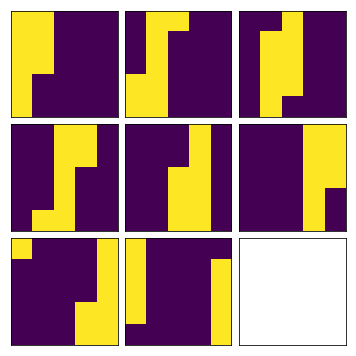

Execution time: at iteration 0 is 8.495486497879028 seconds


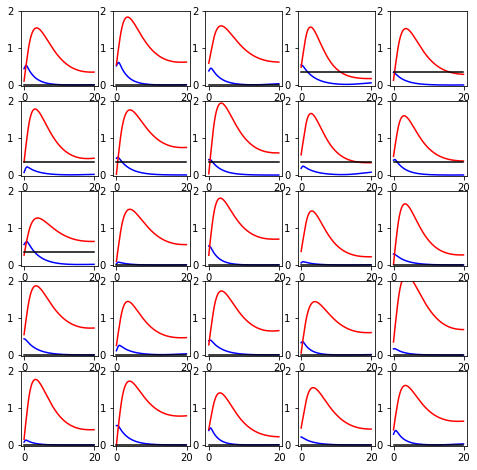

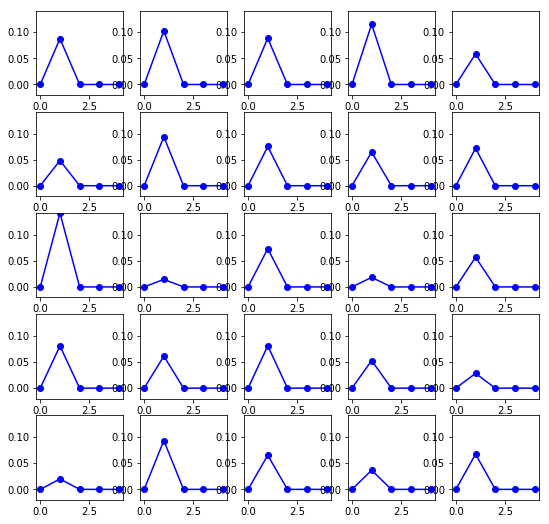

Presentation 1
Execution time: at iteration 1 is 9.00652527809143 seconds
Execution time: at iteration 2 is 9.071688413619995 seconds
Execution time: at iteration 3 is 8.799176931381226 seconds
Execution time: at iteration 4 is 8.724600315093994 seconds
Execution time: at iteration 5 is 9.010707378387451 seconds
Execution time: at iteration 6 is 8.995561361312866 seconds
Execution time: at iteration 7 is 8.895288705825806 seconds
Execution time: at iteration 8 is 8.486586093902588 seconds
Execution time: at iteration 9 is 8.43031907081604 seconds
Execution time: at iteration 10 is 8.312992095947266 seconds
Execution time: at iteration 11 is 8.60933232307434 seconds
Execution time: at iteration 12 is 8.350871562957764 seconds
Execution time: at iteration 13 is 8.314801216125488 seconds
Execution time: at iteration 14 is 8.421431541442871 seconds
Execution time: at iteration 15 is 8.6971275806427 seconds
Execution time: at iteration 16 is 8.556176900863647 seconds
Execution time: at iter

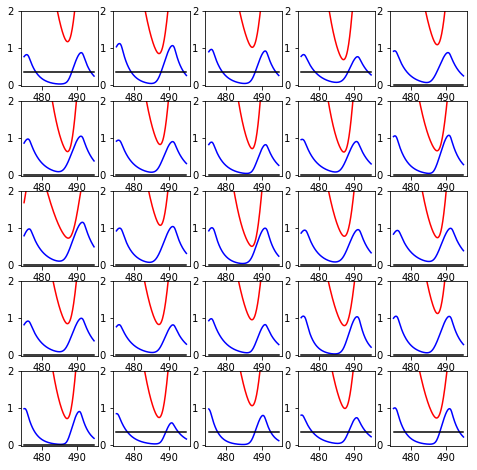

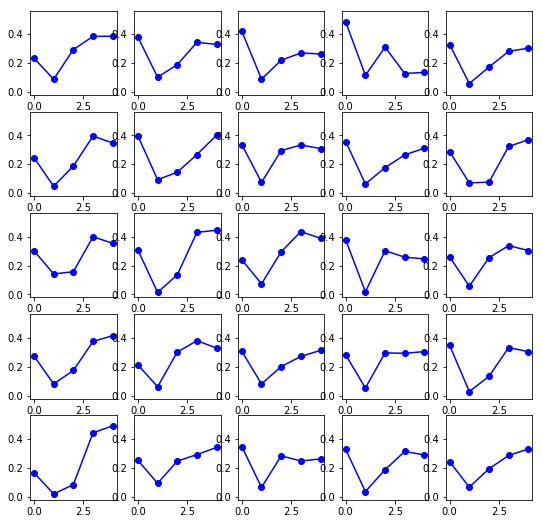

Presentation 20
Execution time: at iteration 20 is 8.37056565284729 seconds
Execution time: at iteration 21 is 8.326245546340942 seconds
Execution time: at iteration 22 is 8.309362411499023 seconds
Execution time: at iteration 23 is 8.77632474899292 seconds
Execution time: at iteration 24 is 9.069088697433472 seconds
Execution time: at iteration 25 is 8.95421028137207 seconds
Execution time: at iteration 26 is 8.646382570266724 seconds
Execution time: at iteration 27 is 8.423976182937622 seconds
Execution time: at iteration 28 is 8.694256782531738 seconds
Execution time: at iteration 29 is 8.618775606155396 seconds
Execution time: at iteration 30 is 8.911513090133667 seconds
Execution time: at iteration 31 is 9.260135173797607 seconds
Execution time: at iteration 32 is 8.498038053512573 seconds
Execution time: at iteration 33 is 8.294591188430786 seconds
Execution time: at iteration 34 is 8.359004497528076 seconds
Execution time: at iteration 35 is 8.583977937698364 seconds
Execution t

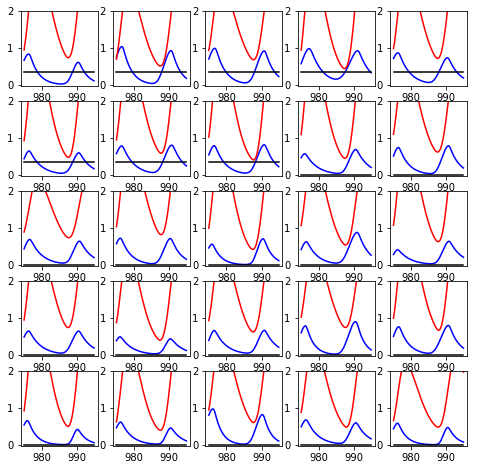

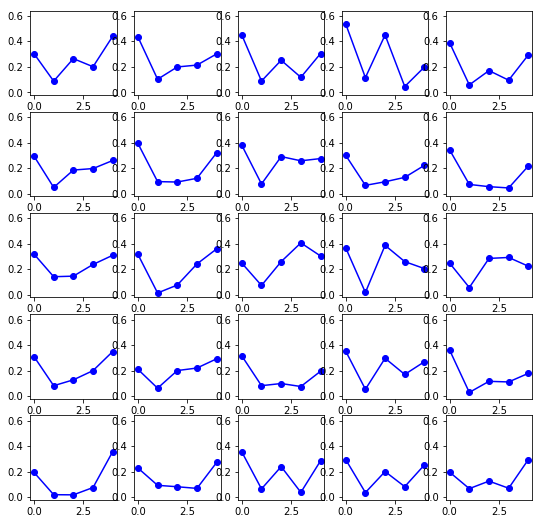

Presentation 40
Execution time: at iteration 40 is 8.442728757858276 seconds
Execution time: at iteration 41 is 8.600263595581055 seconds
Execution time: at iteration 42 is 8.348098516464233 seconds
Execution time: at iteration 43 is 8.551254272460938 seconds
Execution time: at iteration 44 is 8.944484949111938 seconds
Execution time: at iteration 45 is 8.781424760818481 seconds
Execution time: at iteration 46 is 8.681092977523804 seconds
Execution time: at iteration 47 is 8.821682214736938 seconds
Execution time: at iteration 48 is 8.690542459487915 seconds
Execution time: at iteration 49 is 8.535272598266602 seconds
Execution time: at iteration 50 is 8.338671207427979 seconds
Execution time: at iteration 51 is 8.472158193588257 seconds
Execution time: at iteration 52 is 8.58336067199707 seconds
Execution time: at iteration 53 is 8.628879308700562 seconds
Execution time: at iteration 54 is 8.986706256866455 seconds
Execution time: at iteration 55 is 8.80922245979309 seconds
Execution 

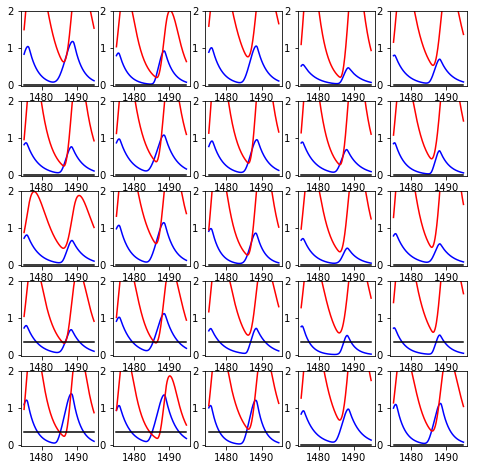

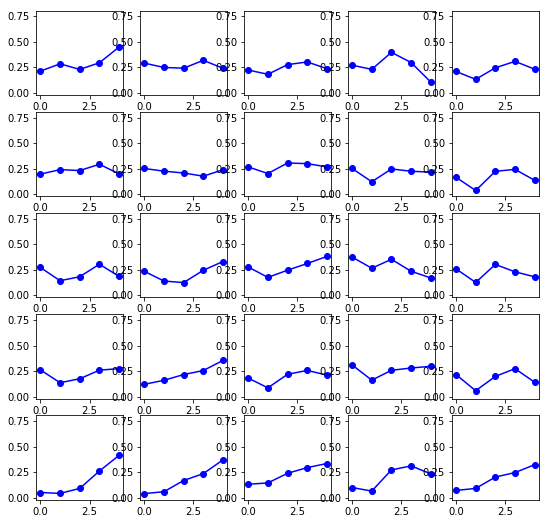

Presentation 60
Execution time: at iteration 60 is 8.603805780410767 seconds
Execution time: at iteration 61 is 8.944969415664673 seconds
Execution time: at iteration 62 is 8.779950380325317 seconds
Execution time: at iteration 63 is 8.750718832015991 seconds
Execution time: at iteration 64 is 8.618191242218018 seconds
Execution time: at iteration 65 is 8.947004556655884 seconds
Execution time: at iteration 66 is 8.82784914970398 seconds
Execution time: at iteration 67 is 8.71373987197876 seconds
Execution time: at iteration 68 is 8.634587049484253 seconds
Execution time: at iteration 69 is 8.725321531295776 seconds
Execution time: at iteration 70 is 9.436578035354614 seconds
Execution time: at iteration 71 is 8.83174180984497 seconds
Execution time: at iteration 72 is 9.065797567367554 seconds
Execution time: at iteration 73 is 8.904622554779053 seconds
Execution time: at iteration 74 is 8.656632661819458 seconds
Execution time: at iteration 75 is 8.668205261230469 seconds
Execution t

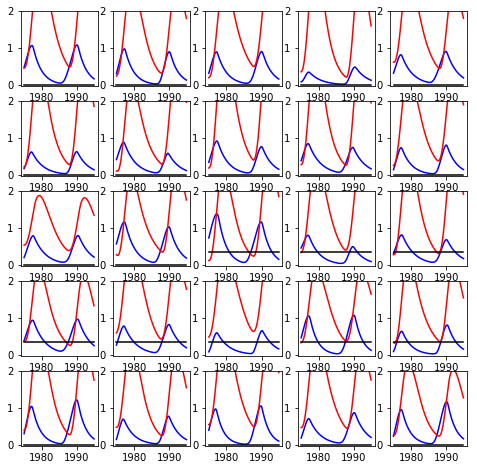

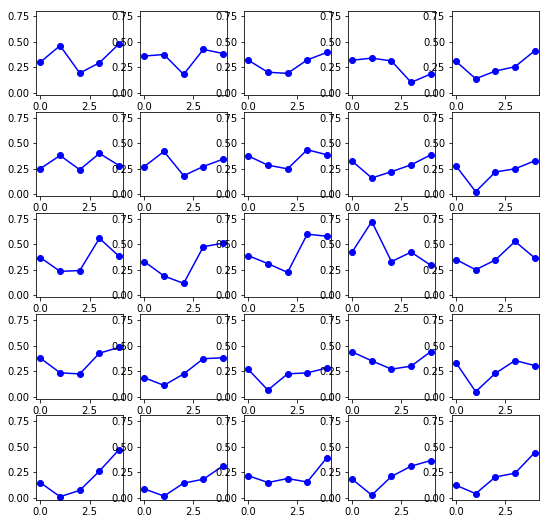

Presentation 80
Execution time: at iteration 80 is 9.184550046920776 seconds
Execution time: at iteration 81 is 9.215502500534058 seconds
Execution time: at iteration 82 is 8.86450481414795 seconds
Execution time: at iteration 83 is 8.722289323806763 seconds
Execution time: at iteration 84 is 8.868969202041626 seconds
Execution time: at iteration 85 is 8.975263595581055 seconds
Execution time: at iteration 86 is 9.287220001220703 seconds
Execution time: at iteration 87 is 8.999558687210083 seconds
Execution time: at iteration 88 is 9.636123895645142 seconds
Execution time: at iteration 89 is 9.387920618057251 seconds
Execution time: at iteration 90 is 9.7052321434021 seconds
Execution time: at iteration 91 is 9.239480257034302 seconds
Execution time: at iteration 92 is 9.342630863189697 seconds
Execution time: at iteration 93 is 9.174278259277344 seconds
Execution time: at iteration 94 is 9.895792722702026 seconds
Execution time: at iteration 95 is 9.347543716430664 seconds
Execution t

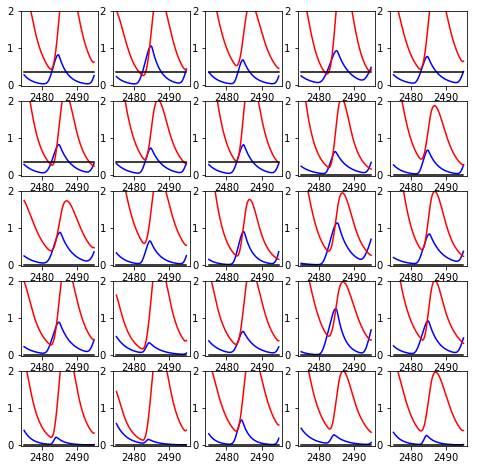

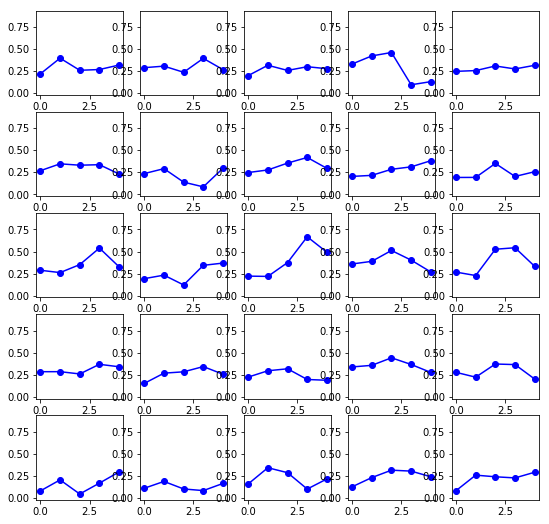

Presentation 100
Execution time: at iteration 100 is 9.001658201217651 seconds
Execution time: at iteration 101 is 9.387384414672852 seconds
Execution time: at iteration 102 is 9.15556263923645 seconds
Execution time: at iteration 103 is 8.520902633666992 seconds
Execution time: at iteration 104 is 8.513214349746704 seconds
Execution time: at iteration 105 is 8.74697732925415 seconds
Execution time: at iteration 106 is 8.94397759437561 seconds
Execution time: at iteration 107 is 9.04152226448059 seconds
Execution time: at iteration 108 is 9.477688550949097 seconds
Execution time: at iteration 109 is 8.90503191947937 seconds
Execution time: at iteration 110 is 8.620115756988525 seconds
Execution time: at iteration 111 is 8.77591061592102 seconds
Execution time: at iteration 112 is 8.70288634300232 seconds
Execution time: at iteration 113 is 9.111785650253296 seconds
Execution time: at iteration 114 is 9.83096718788147 seconds
Execution time: at iteration 115 is 10.904664993286133 second

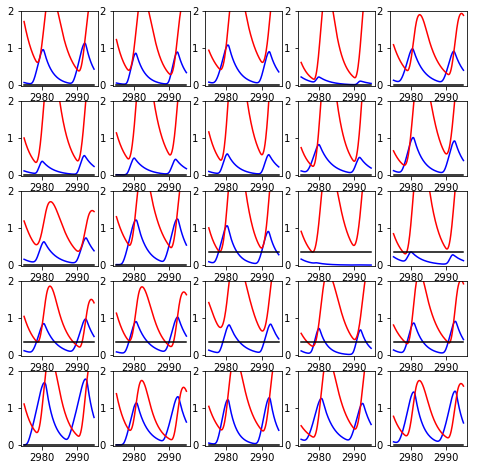

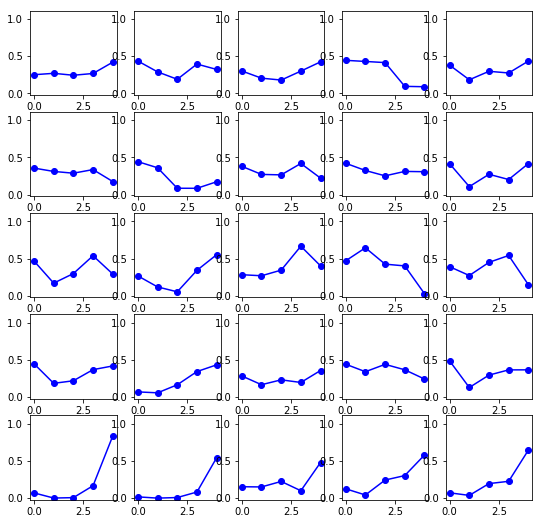

Presentation 120
Execution time: at iteration 120 is 8.830283880233765 seconds
Execution time: at iteration 121 is 8.880536317825317 seconds
Execution time: at iteration 122 is 8.810967206954956 seconds
Execution time: at iteration 123 is 8.61294174194336 seconds
Execution time: at iteration 124 is 8.506664991378784 seconds
Execution time: at iteration 125 is 8.451185941696167 seconds
Execution time: at iteration 126 is 8.456079006195068 seconds
Execution time: at iteration 127 is 8.669174671173096 seconds
Execution time: at iteration 128 is 8.519096374511719 seconds
Execution time: at iteration 129 is 8.894676685333252 seconds
Execution time: at iteration 130 is 8.99319577217102 seconds
Execution time: at iteration 131 is 8.857822179794312 seconds
Execution time: at iteration 132 is 8.65183138847351 seconds
Execution time: at iteration 133 is 8.449793815612793 seconds
Execution time: at iteration 134 is 8.528596878051758 seconds
Execution time: at iteration 135 is 8.964243412017822 se

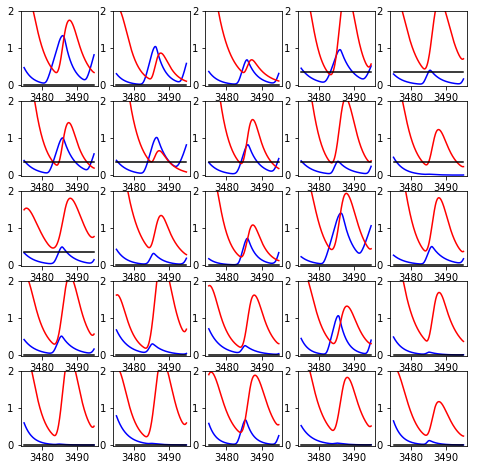

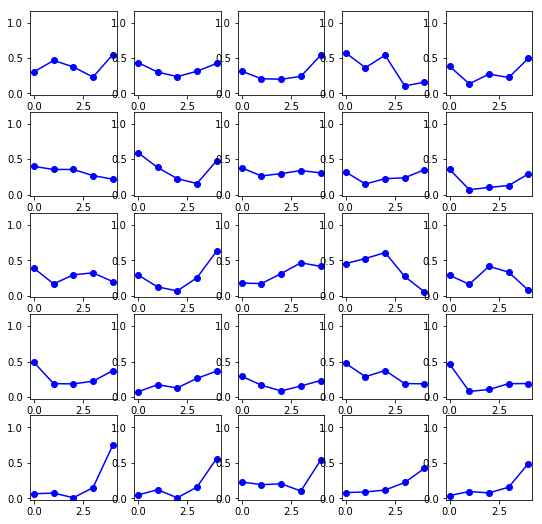

Presentation 140
Execution time: at iteration 140 is 8.763489246368408 seconds
Execution time: at iteration 141 is 8.44168758392334 seconds
Execution time: at iteration 142 is 8.860675573348999 seconds
Execution time: at iteration 143 is 8.774075746536255 seconds
Execution time: at iteration 144 is 8.656998872756958 seconds
Execution time: at iteration 145 is 8.797617673873901 seconds
Execution time: at iteration 146 is 8.833571195602417 seconds
Execution time: at iteration 147 is 8.78689169883728 seconds
Execution time: at iteration 148 is 8.872270345687866 seconds
Execution time: at iteration 149 is 8.62134861946106 seconds
Execution time: at iteration 150 is 9.044943809509277 seconds
Execution time: at iteration 151 is 9.241463899612427 seconds
Execution time: at iteration 152 is 9.635624885559082 seconds
Execution time: at iteration 153 is 9.249588251113892 seconds
Execution time: at iteration 154 is 9.04326581954956 seconds
Execution time: at iteration 155 is 9.064276456832886 sec

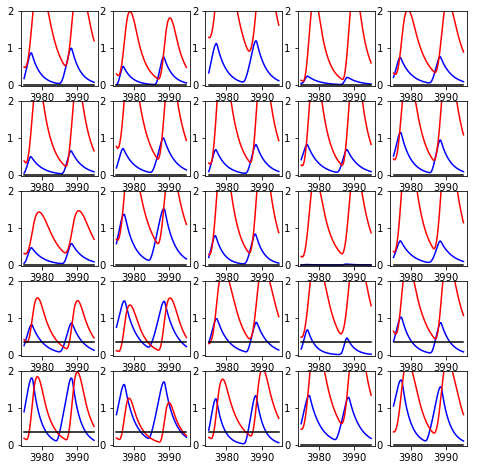

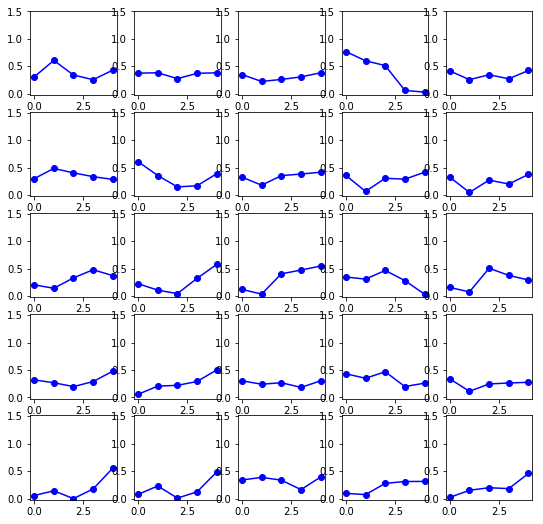

Presentation 160


In [3]:
sel = selection()
sel.build('snake')
sel.display_inputs()
n_pres = 160
n_disp = 8
sel.run(n_pres, n_disp)

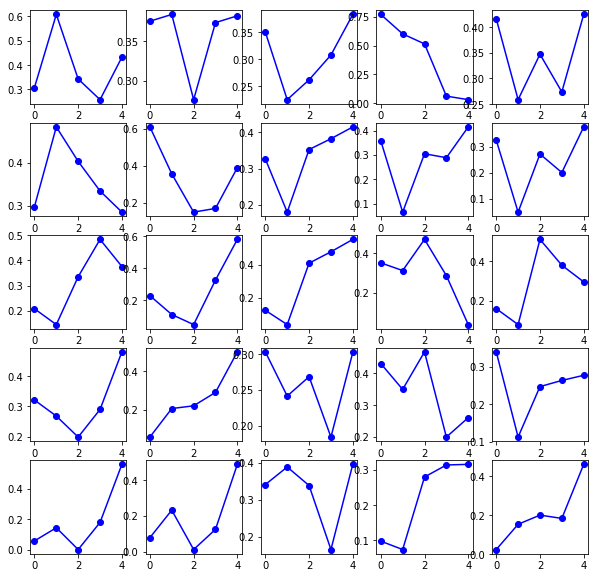

In [4]:
# For each unit, plot its avg. response for each pattern
all_avg_fig = plt.figure(figsize=(10,10))
avg_res = sel.all_avg_res[-1]
N = sel.N
for res in avg_res:
    res.shape = N*N
for u in range(N*N):
    ax = all_avg_fig.add_subplot(N,N,u+1)
    ax.plot(range(N), [avg_res[i][u] for i in range(N)], 'bo-')
    
plt.show()

In [5]:
# For each unit, plot its avg. response for each pattern and for each presentation, as a movie
from matplotlib.animation import FuncAnimation
%matplotlib notebook
all_avg_fig = plt.figure(figsize=(8,8))
N = sel.N
n_pats = len(sel.patterns)
    
for pres in sel.all_avg_res:
    for res in pres:
        res.shape = N*N

for u in range(N*N):
    ax = all_avg_fig.add_subplot(N,N,u+1)

largest = max([max([max(sel.all_avg_res[a][b]) for b in range(n_pats)]) for a in range(n_pres)])
def update(frame):
    pres = frame%n_pres
    for u in range(N*N):
        ax = all_avg_fig.add_subplot(N,N,u+1)
        ax.clear()
        ax.plot(range(n_pats), [sel.all_avg_res[pres][i][u] for i in range(n_pats)], 'bo-')
        plt.ylim([-0.02, largest])
    return ax,

animation = FuncAnimation(all_avg_fig, update, interval=50, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [6]:
#sel.animate_responses(50)

In [7]:
# visualize the patterns in a grid
inp_fig = plt.figure(figsize=(6,8))
cols = int(np.ceil(np.sqrt(n_pat)))
rows = int(round(np.sqrt(n_pat)))
inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')

for idx,pat in enumerate(patterns):
    copy = pat.copy() # to avoid reshaping the input vectors
    copy.shape = N,N
    copy = np.transpose(copy)
    inp_grid[idx].set_xticks([])
    inp_grid[idx].set_yticks([])
    inp_grid[idx].imshow(copy)
    
plt.show()

# Find the centers of the patterns
centers = [np.zeros(2) for _ in range(len(patterns))]
for num, pat in enumerate(patterns):
    pat_coords = [ u.coordinates for u in [ net.units[i] for i in inp if pat[i - inp[0]] > 0 ] ]
    centers[num] = sum(pat_coords)/len(pat_coords)
    
cen_fig = plt.figure(figsize=(5,5))
plt.scatter([c[0] for c in centers], [c[1] for c in centers])
plt.show()

# print average number of connections of each type
sum_ee = 0 # number of e-e connections
sum_ei = 0
sum_ie = 0
sum_pe = 0 # number of input to exc connections
sum_pi = 0
for syn_list in net.syns:
    for syn in syn_list:
        if syn.postID in exc:
            if syn.preID in exc:
                sum_ee += 1
            elif syn.preID in inh:
                sum_ie += 1
            else:
                sum_pe += 1
        elif syn.postID in inh:
            if syn.preID in exc:
                sum_ei += 1
            else:
                sum_pi += 1
print("Average number of incoming EE connections: %f" % (sum_ee/(N*N)))
print("Average number of incoming EI connections: %f" % (sum_ei/(N*N)))
print("Average number of incoming IE connections: %f" % (sum_ie/(N*N)))
print("Average number of incoming PE connections: %f" % (sum_pe/(N*N)))
print("Average number of incoming PI connections: %f" % (sum_pi/(N*N)))

# Visualize the initial weights
exc_w = [np.zeros(N*N) for _ in range(N*N)]
inh_w = [np.zeros(N*N) for _ in range(N*N)]
inp_w = [np.zeros(N*N) for _ in range(N*N)]
e2i_w = [np.zeros(N*N) for _ in range(N*N)]
for u in exc: # for each excitatory unit, record its incoming weights
    for syn_list in [net.syns[u]]: # recording weights for excitatory units
        for syn in syn_list:
            if syn.preID in exc: # lateral excitatory connection
                exc_w[u-exc[0]][syn.preID-exc[0]] = syn.w
            elif syn.preID in inh: # lateral inhibitory connection
                inh_w[u-exc[0]][syn.preID-inh[0]] = syn.w
            elif syn.preID in inp: # descending connection
                inp_w[u-exc[0]][syn.preID-inp[0]] = syn.w
            else:
                print("What???")
                
for u in inh: # temporary code
    for syn_list in [net.syns[u]]:
        for syn in syn_list:
            if syn.preID in exc:
                e2i_w[u-inh[0]][syn.preID-exc[0]] = syn.w

w_fig = plt.figure(figsize=(20,20))

exw_grid = ImageGrid(w_fig, 221, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,exw in enumerate(exc_w):
    exw.shape = N,N
    exim = exw_grid[idx].imshow(exw)
exw_grid.cbar_axes[0].colorbar(exim)

inw_grid = ImageGrid(w_fig, 222, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,inw in enumerate(inh_w):
    inw.shape = N,N
    inim = inw_grid[idx].imshow(inw)
inw_grid.cbar_axes[0].colorbar(inim)
    
ipw_grid = ImageGrid(w_fig, 223, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,ipw in enumerate(inp_w):   
    ipw.shape = N,N
    ipim = ipw_grid[idx].imshow(ipw)
ipw_grid.cbar_axes[0].colorbar(ipim)

e2i_grid = ImageGrid(w_fig, 224, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,eiw in enumerate(e2i_w):   
    eiw.shape = N,N
    eiim = e2i_grid[idx].imshow(eiw)
e2i_grid.cbar_axes[0].colorbar(eiim)
    
#plt.show()

<IPython.core.display.Javascript object>

NameError: name 'n_pat' is not defined

In [ ]:
'''Run the simulation. '''

### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
n_pres = 121   # number of times some pattern will be presented
n_disp = 4# How many times to store/display simulation data (besides the initial one)
t_pat = 20. # time each pattern will be presented
t_trans = 5. # length of transition period between patterns
interv = int(np.floor(n_pres/n_disp)) # number of iterations per data display
idx_d = 0 # index for display data
c = 1/t_trans # auxiliary variable for make_fun2
pats = range(n_pat) # auxiliary variable to choose a pattern
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0. # simulation time after last pattern presentation, for make_fun2
exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
#e2i_w = [[] for _ in range(n_disp+1)]  # temporarily used for testing
start_time = time.time()

def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    for u in range(N*N):
        net.units[inp[u]].set_function( make_fun1(u) )
    
    start_time = time.time()
    sim_dat = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(N*N):
        net.units[inp[u]].set_function(make_fun2(u, last_t))
    
    sim_dat2 = net.run(t_trans) # simulating
    
    print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    if pres == 0 or (pres+1)%interv == 0:
        plot_stuff(sim_dat, exc, inh, inp)
        plot_stuff(sim_dat2, exc, inh, inp)
        # store the synaptic weights
        exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        #e2i_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        for u in exc: # for each excitatory unit, record its incoming weights
            for syn_list in [net.syns[u]]: # recording weights for excitatory units
                for syn in syn_list:
                    if syn.preID in exc: # lateral excitatory connection
                        exc_w[idx_d][u][syn.preID-exc[0]] = syn.w
                    elif syn.preID in inh: # lateral inhibitory connection
                        inh_w[idx_d][u][syn.preID-inh[0]] = syn.w
                    elif syn.preID in inp: # descending connection
                        inp_w[idx_d][u][syn.preID-inp[0]] = syn.w
                    else:
                        print("What???")
                        
        print('Presentation ' + str(pres+1))
        idx_d += 1

In [ ]:
# visualize the weights in a grid

for vis in range(n_disp):
    w_fig = plt.figure(figsize=(30,10))

    exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,exw in enumerate(exc_w[vis]):
        exw.shape = N,N
        exim = exw_grid[idx].imshow(exw)
    exw_grid.cbar_axes[0].colorbar(exim)
    
    inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,inw in enumerate(inh_w[vis]):
        inw.shape = N,N
        inim = inw_grid[idx].imshow(inw)
    inw_grid.cbar_axes[0].colorbar(inim)
    
    ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,ipw in enumerate(inp_w[vis]):
        ipw.shape = N,N
        ipim = ipw_grid[idx].imshow(ipw)
    ipw_grid.cbar_axes[0].colorbar(ipim)
    
    plt.show()
    
# see how the sum of each type of input evolves for unit 0
exc_sums = [sum(sum(exc_w[ii][0]*exc_w[ii][0])) for ii in range(n_disp)]
inh_sums = [sum(sum(inh_w[ii][0])) for ii in range(n_disp)]
inp_sums = [sum(sum(inp_w[ii][0])) for ii in range(n_disp)]
print("Excitatory sums:", end='\t')
print(exc_sums)
print("Inhibitory sums:", end='\t')
print(inh_sums)
print("External input sums:", end=' \t')
print(inp_sums)


The point of these simulations is to find whether the E-I network with the type of plasticity from Moldakarinov06 is suited for becoming a network where each unit selects a particular subset of the descending inputs.

Due to the topological arrangement of the connections, it is reasonable to assume that spatially structured inputs, such as the "progressive lines" will have patterns that target some units slightly more than others. The point is for the network to pick on those slight preferences and to enhance them using the lateral connections as exta constraints.

In the case of the progressive lines we can: 
* find a 'center' for each pattern, as the average of the coordinates for each unit that is on when the pattern is present. That's the 'centers' vector obtained above.
* for each excitatory unit, measure its average activity level for each pattern. 
* plot what is the correlation between the distance to a pattern VS the activity level when the pattern is presented.
  This can be done in first vs last iterations.

In [ ]:
""" Next, test if the cells are selective to some of the patterns. Present the five patterns,
and see the average response value. """
avg_res = [np.zeros(N*N) for _ in range(n_pat)] # for each pattern, average activity of each unit

# presenting all paterns
for num, pat in enumerate(patterns):
    # first, we present a single pattern
    cur_pat = num
    for u in range(N*N):
        net.units[inp[u]].set_function( make_fun1(u) )
    
    start_time = time.time()
    times, units, plants = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    
    for u in range(N*N):
        avg_res[num][u] = sum(units[exc[u]]) / len(units[exc[u]])
    
    # now one pattern turns into the next
    for u in range(N*N):
        net.units[inp[u]].set_function(make_fun2(u, last_t))
    
    sim_dat2 = net.run(t_trans) # simulating
    
    print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
    plot_stuff((times, units, plants), exc, inh, inp)
    print('Presented pattern: ' + str(num))
    
    # plot a grid with the average responses
    avg_fig, avg_ax = plt.subplots()
    avg_res[num].shape = N,N 
    avg_ax.imshow(avg_res[num])
    plt.show()
    

In [ ]:
# For each unit, plot its avg. response for each pattern
all_avg_fig = plt.figure(figsize=(10,10))
for res in avg_res:
    res.shape = N*N
for u in range(N*N):
    ax = all_avg_fig.add_subplot(N,N,u+1)
    ax.plot(range(N), [avg_res[i][u] for i in range(N)], 'bo-')
    
plt.show()

This figure shows that units become very selective to particular patterns, and the number of units devoted to each pattern is evenly distributed. It is not quite how I imagined it, but it couldn't be better.

In [ ]:
gas = [[(20,3,17),4033], [(17,2,17), 4410], [(12,1,17),4511], [(27,11,16),3586], [(24,10,16),4153], [(5,10,16),3796],
 [(26,9,16),2000], [(31,7,17), 3992], [(9,6,17), 4824], [(24,4,17), 4811], [(5,7,17), 4810], [(6,11,16),3410],
 [(16,7,17), 4783]]
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cumdays = [days[0]] + [0] * 11
for i in range(1,12):
    cumdays[i] = days[i] + cumdays[i-1]
dates = [ e[0][0] + cumdays[e[0][1]] + sum(days)*(e[0][2] - 16) for e in gas]
prices = [e[1] for e in gas]
fig = plt.figure(figsize=(12,8))
plt.plot(dates, prices, 'o')
plt.show()

In [ ]:
sal = [(504166,434771), (502174,417117), (502166,415909), (502166,417114), (502166,418314), (502166,418314), 
 (502166,420851), (502166,421251), (502166,420899), (491666,411939), (491666,412339), (491666,411939)]
sum([a[1] for a in sal])

In [ ]:
max(np.array([1,2,3]))